# 1. 数据准备
首先，导入Iris数据集并分割成训练集和测试集。

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data
y = iris.target

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# 2. 利用最近邻法进行分类

In [3]:
accuracy_dict = {}

In [4]:
import numpy as np

class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            nearest_neighbors = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_neighbors]
            most_common_label = np.argmax(np.bincount(nearest_labels))
            y_pred.append(most_common_label)
        return np.array(y_pred)

# 创建自己实现的最近邻分类器
knn_classifier = KNNClassifier(k=3)

# 使用训练集进行训练
knn_classifier.fit(X_train, y_train)

# 预测测试集
y_pred = knn_classifier.predict(X_test)

# 显示分类结果和分类精度
accuracy = np.sum(y_test == y_pred) / len(y_test)
print("最近邻法分类结果和精度:")
print("预测结果:", y_pred)
print("真实标签:", y_test)
print("分类精度:", accuracy)

accuracy_dict['原始样本'] = accuracy

最近邻法分类结果和精度:
预测结果: [2 1 0 2 0 2 0 1 1 1 2 1 1 1 2 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
真实标签: [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
分类精度: 0.9666666666666667


# 3.K-L变换

In [5]:
import numpy as np

class KLDimensionalityReduction:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean_vector = None
        self.eigenvectors = None

    def fit_transform(self, X, y, scatter_matrix_type='class'):
        # 计算均值向量
        self.mean_vector = np.mean(X, axis=0)

        if scatter_matrix_type == 'class':
            scatter_matrix = self._compute_class_scatter_matrix(X, y)
        elif scatter_matrix_type == 'total':
            scatter_matrix = self._compute_total_scatter_matrix(X)
        elif scatter_matrix_type == 'auto':
            scatter_matrix = self._compute_con_matrix(X)
        else:
            raise ValueError("Invalid scatter_matrix_type. Use 'class', 'total', or 'auto'.")

        # 计算特征值和特征向量
        eigenvalues, eigenvectors = np.linalg.eig(scatter_matrix)

        # 排序特征值和对应的特征向量
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.eigenvectors = eigenvectors[:, sorted_indices[:self.n_components]]

        # 映射到新特征空间
        X_transformed = np.dot(X - self.mean_vector, self.eigenvectors)

        return X_transformed

    def _compute_class_scatter_matrix(self, X, y):
        unique_classes = np.unique(y)
        class_scatter_matrix = np.zeros((X.shape[1], X.shape[1]))

        for cls in unique_classes:
            X_cls = X[y == cls]
            mean_vector_cls = np.mean(X_cls, axis=0)
            class_scatter_matrix += len(X_cls) * np.outer((mean_vector_cls - self.mean_vector), (mean_vector_cls - self.mean_vector))

        return class_scatter_matrix

    def _compute_total_scatter_matrix(self, X):
        total_scatter_matrix = np.cov((X - self.mean_vector).T)
        return total_scatter_matrix

    def _compute_con_matrix(self, X):
        return np.dot(X.T, X)

## 3.1 自相关矩阵

In [6]:
kld = KLDimensionalityReduction(n_components=2)
X_train_kld1 = kld.fit_transform(X_train, y_train, scatter_matrix_type='auto')
X_test_kld1 = kld.fit_transform(X_test, y_test, scatter_matrix_type='auto')

knn_classifier = KNNClassifier(k=3)
knn_classifier.fit(X_train_kld1, y_train)
y_pred = knn_classifier.predict(X_test_kld1)

# 显示分类结果和分类精度
accuracy = np.sum(y_test == y_pred) / len(y_test)
print("最近邻法分类结果和精度:")
print("预测结果:", y_pred)
print("真实标签:", y_test)
print("分类精度:", accuracy)

accuracy_dict['K-L变换（自相关矩阵）'] = accuracy

最近邻法分类结果和精度:
预测结果: [2 1 0 2 0 2 0 1 2 1 2 1 2 2 2 0 2 1 0 0 2 1 0 0 2 0 0 1 1 0]
真实标签: [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
分类精度: 0.8333333333333334


C:\Users\ishine\AppData\Local\Temp\ipykernel_22952\3965251911.py:15: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='Feature1', y='Feature2', hue='Label', style='Label', data=df, palette='viridis', markers=['o', 's'], edgecolor='k')


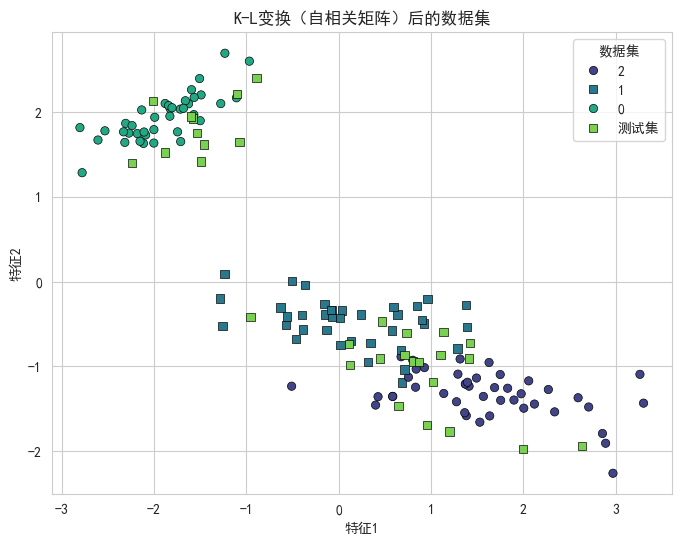

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_train = pd.DataFrame(X_train_kld1, columns=['Feature1', 'Feature2'])
df_train['Label'] = y_train

df_test = pd.DataFrame(X_test_kld1, columns=['Feature1', 'Feature2'])
df_test['Label'] = '测试集'

df = pd.concat([df_train, df_test], axis=0)

# 使用Seaborn绘制散点图
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Feature1', y='Feature2', hue='Label', style='Label', data=df, palette='viridis', markers=['o', 's'], edgecolor='k')
plt.title('K-L变换（自相关矩阵）后的数据集')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend(title='数据集', loc='upper right')
plt.show()

## 3.2 类间散布矩阵

In [8]:
kld = KLDimensionalityReduction(n_components=2)
X_train_kld2 = kld.fit_transform(X_train, y_train, scatter_matrix_type='class')
X_test_kld2 = kld.fit_transform(X_test, y_test, scatter_matrix_type='class')

knn_classifier = KNNClassifier(k=3)
knn_classifier.fit(X_train_kld2, y_train)
y_pred = knn_classifier.predict(X_test_kld2)

# 显示分类结果和分类精度
accuracy = np.sum(y_test == y_pred) / len(y_test)
print("最近邻法分类结果和精度:")
print("预测结果:", y_pred)
print("真实标签:", y_test)
print("分类精度:", accuracy)

accuracy_dict['K-L变换（类间散布矩阵）'] = accuracy

最近邻法分类结果和精度:
预测结果: [2 1 0 2 0 2 0 2 2 1 2 2 1 1 2 0 2 1 0 0 2 1 0 0 2 0 0 1 1 0]
真实标签: [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
分类精度: 0.8333333333333334


C:\Users\ishine\AppData\Local\Temp\ipykernel_22952\2771449721.py:15: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='Feature1', y='Feature2', hue='Label', style='Label', data=df, palette='viridis', markers=['o', 's'], edgecolor='k')
D:\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\dtypes\astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
D:\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\dtypes\astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


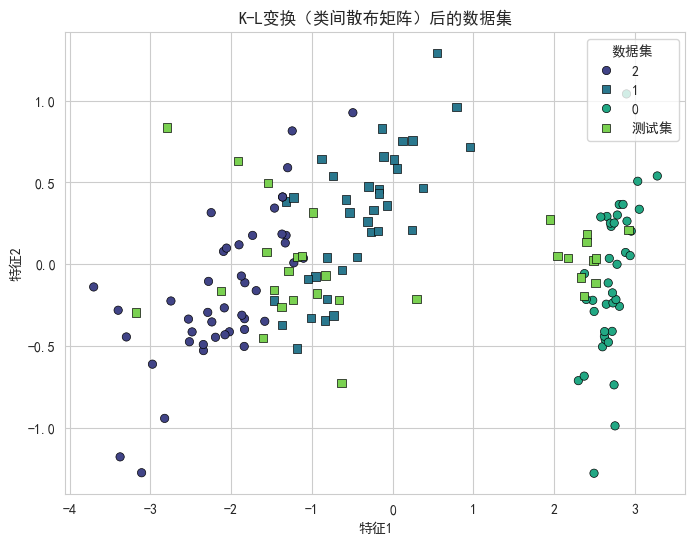

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_train = pd.DataFrame(X_train_kld2, columns=['Feature1', 'Feature2'])
df_train['Label'] = y_train

df_test = pd.DataFrame(X_test_kld2, columns=['Feature1', 'Feature2'])
df_test['Label'] = '测试集'

df = pd.concat([df_train, df_test], axis=0)

# 使用Seaborn绘制散点图
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Feature1', y='Feature2', hue='Label', style='Label', data=df, palette='viridis', markers=['o', 's'], edgecolor='k')
plt.title('K-L变换（类间散布矩阵）后的数据集')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend(title='数据集', loc='upper right')
plt.show()

## 3.3 总体散布矩阵

In [10]:
kld = KLDimensionalityReduction(n_components=2)
X_train_kld3 = kld.fit_transform(X_train, y_train, scatter_matrix_type='total')
X_test_kld3 = kld.fit_transform(X_test, y_test, scatter_matrix_type='total')

knn_classifier = KNNClassifier(k=3)
knn_classifier.fit(X_train_kld3, y_train)
y_pred = knn_classifier.predict(X_test_kld3)

# 显示分类结果和分类精度
accuracy = np.sum(y_test == y_pred) / len(y_test)
print("最近邻法分类结果和精度:")
print("预测结果:", y_pred)
print("真实标签:", y_test)
print("分类精度:", accuracy)

accuracy_dict['K-L变换（总体散布矩阵）'] = accuracy

最近邻法分类结果和精度:
预测结果: [2 1 0 2 0 2 0 1 1 1 2 1 2 1 2 0 2 1 0 0 2 1 0 0 2 0 0 1 1 0]
真实标签: [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
分类精度: 0.9


C:\Users\ishine\AppData\Local\Temp\ipykernel_22952\2037053744.py:15: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='Feature1', y='Feature2', hue='Label', style='Label', data=df, palette='viridis', markers=['o', 's'], edgecolor='k')
D:\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\dtypes\astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
D:\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\dtypes\astype.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


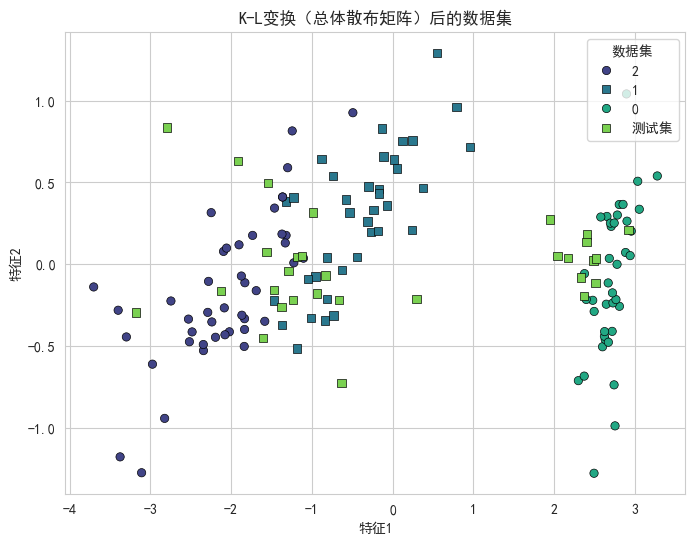

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_train = pd.DataFrame(X_train_kld2, columns=['Feature1', 'Feature2'])
df_train['Label'] = y_train

df_test = pd.DataFrame(X_test_kld2, columns=['Feature1', 'Feature2'])
df_test['Label'] = '测试集'

df = pd.concat([df_train, df_test], axis=0)

# 使用Seaborn绘制散点图
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Feature1', y='Feature2', hue='Label', style='Label', data=df, palette='viridis', markers=['o', 's'], edgecolor='k')
plt.title('K-L变换（总体散布矩阵）后的数据集')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend(title='数据集', loc='upper right')
plt.show()

# 4 绘制对比图

C:\Users\ishine\AppData\Local\Temp\ipykernel_22952\3245812800.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='准确度', y='数据集', data=df_accuracy, palette='viridis')


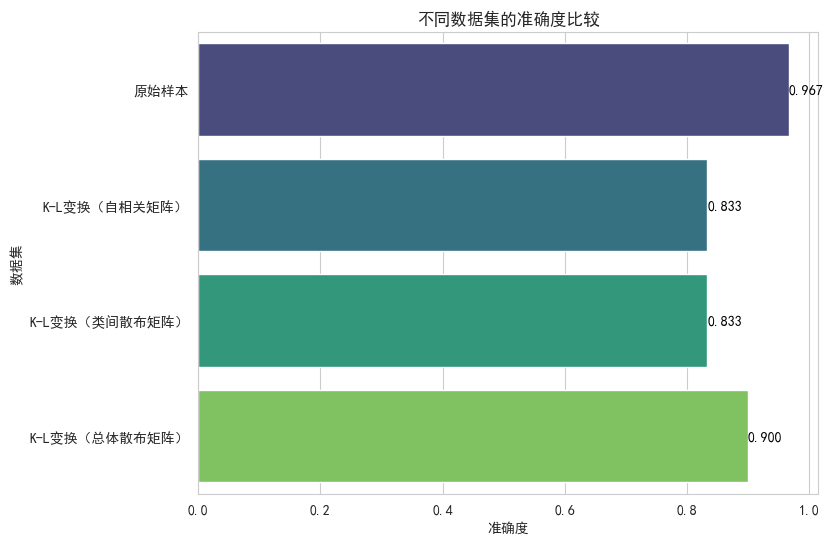

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 将字典转换为 DataFrame
df_accuracy = pd.DataFrame(list(accuracy_dict.items()), columns=['数据集', '准确度'])

# 使用Seaborn绘制条形图
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='准确度', y='数据集', data=df_accuracy, palette='viridis')

# 在每个条形上标出数值
for index, value in enumerate(df_accuracy['准确度']):
    ax.text(value, index, f'{value:.3f}', ha='left', va='center', fontsize=10, color='black')

plt.title('不同数据集的准确度比较')
plt.xlabel('准确度')
plt.ylabel('数据集')
plt.show()
